# Introduction

As a person who loves eating cereal and chicken, I am curious about these products in the country I am living - Argentina. With the suggestion of a classmate - Viktor, I delved into this webpage https://ourworldindata.org/country/argentina and focused on data about food and agriculture in Argentina. I bumped into interesting data about annual cereal production and chicken production in Argentina. With the knowledge that cereal gains can be used to feed chicken, I am curious if there is any correlation between chicken and cereal production here. This paper will use different models to analyze linear regression between chicken production as a predictor and cereal production as a response as well as compare between models.

# Dataset

The data record annual cereal production and chicken production in Argentina from 1961 to 2020. I preprocessed data a bit to focus only in Argentina, merged data on the year and got an ideal dataframe to work with 2 main variables here.

In [1]:
# import libraries for the paper
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc as pm
import scipy.stats as sts

cereal_data = pd.read_csv("cereal-production.csv")
chicken_data = pd.read_csv("chicken-meat-production.csv")

xdata = chicken_data[chicken_data['Entity'] == 'Argentina']
ydata = cereal_data[cereal_data['Entity'] == 'Argentina']

# only get the production values
chicken = xdata.iloc[:, -1]
cereal = ydata.iloc[:, -1]

# create a dataframe
chicken = np.array(chicken)
cereal = np.array(cereal)
dataset = pd.DataFrame({'chicken' : chicken, 'cereal' : cereal}, columns = ['chicken', 'cereal'])
dataset.head()

/Users/ngttam3010/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ngttam3010/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


,chicken,cereal
0,36241,14512100
1,43474,13961600
2,53928,17331100
3,76194,20821300
4,118194,13843800


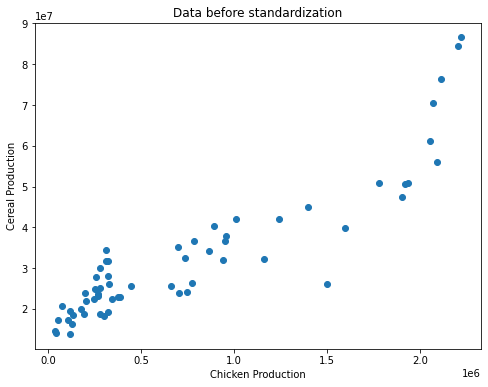

In [2]:
plt.figure(figsize=(8, 6))
plt.scatter(dataset.chicken, dataset.cereal)
plt.title('Data before standardization')
plt.xlabel('Chicken Production')
plt.ylabel('Cereal Production')
plt.show()

I noticed that values of cereal production and chicken production lie in different scales. Therefore, I decided to standardize data of both the predictor and the outcome to bring both variables to the same scale of values and achieve better data quality for the model.

<ipython-input-3-01a86b05b840>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.chicken_std = (dataset.chicken - dataset.chicken.mean()) / dataset.chicken.std()
<ipython-input-3-01a86b05b840>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.chicken_std2 = dataset.chicken_std ** 2
<ipython-input-3-01a86b05b840>:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset.cereal_std = (dataset.cereal - dataset.cereal.mean()) / dataset.cereal.std()
<ipython-input-3-01a86b05b840>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#a

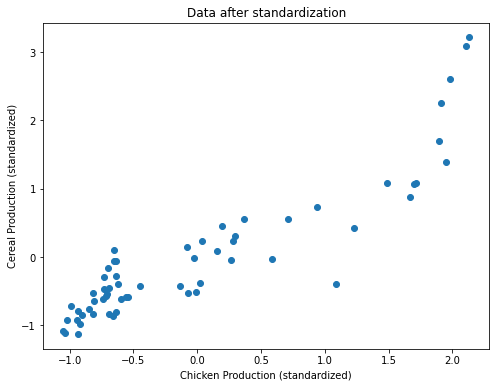

In [3]:
dataset.chicken_std = (dataset.chicken - dataset.chicken.mean()) / dataset.chicken.std()
dataset.chicken_std2 = dataset.chicken_std ** 2

dataset.cereal_std = (dataset.cereal - dataset.cereal.mean()) / dataset.cereal.std()
dataset.cereal_std2 = dataset.cereal_std ** 2

plt.figure(figsize=(8, 6))
plt.scatter(dataset.chicken_std, dataset.cereal_std)
plt.title('Data after standardization')
plt.xlabel('Chicken Production (standardized)')
plt.ylabel('Cereal Production (standardized)')
plt.show()

# Models

### 1. Normal Model

At first glance of the scatterplot, data seems to have a relationship and we can totally build a model to fit the data. However, with linear regression, we need to consider what is the best degree for polynomials to construct the regression function. To compare between polynomials of different degrees, I will use log-model evidence values corresponding to each degree. This metric prefers better accuracy than deviance metric by measuring the probability data are generated from a model given inputted parameters. The biggest downside of log-model evidence is complicated calculations. However, our model here is not too complex yet and with the help of PyMC computational tools, we can work around that.

In [4]:
result = []
for degree in [1, 2, 3, 4, 5]:
    with pm.Model() as m:
        # Noise scale
        sigma = pm.Uniform('sigma', lower=0, upper=20)
        # Constant term
        alpha = pm.Uniform('alpha', lower=0, upper=10)
        # Coefficients of the x^i terms
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        # Compute the mean of the polynomial given the alpha and beta coefficients
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * dataset.chicken_std ** i
        mu = pm.Deterministic('mu', mu)
        # Likelihood
        y = pm.Normal('y', mu=mu, sigma=sigma, observed=dataset.cereal_std)

        approx = pm.fit(50000, progressbar=False)

    log_evidence = -np.mean(approx.hist[-10000:])
    result.append(log_evidence)
    print(f'log evidence for degree {degree}:', log_evidence)

Finished [100%]: Average Loss = 48.166


log evidence for degree 1: -47.80655960579


Finished [100%]: Average Loss = 50.228


log evidence for degree 2: -50.08863122800901


Finished [100%]: Average Loss = 36.56


log evidence for degree 3: -36.43819912574293


Finished [100%]: Average Loss = 38.106


log evidence for degree 4: -38.21932772377398


Finished [100%]: Average Loss = 43.044


log evidence for degree 5: -43.96336569331446


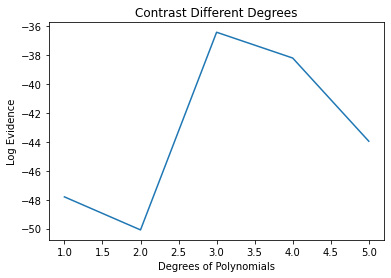

In [5]:
params = [1, 2, 3, 4, 5]
plt.plot(params, result)
plt.title("Contrast Different Degrees")
plt.xlabel("Degrees of Polynomials")
plt.ylabel("Log Evidence")
plt.show()

From the result and visualization above, we can tell that **3 is the ideal degree of polynomial** for our regression model. With small degrees, the model might underfit while overfitting can be risky with large degrees.

#### a. Model

Setting ranges for the prior is very important to fit data. Here, we need to ignore data we have seen as we preprocess at the beginning. After standardization, I suppose data should not incorporate any too big values. The units of chicken and cereal production are both millions of tonnes already, so values just fall in the range [0, 20] at most. For the Intercept, I chose a Uniform distribution from 0 to 10 because production is not supposed to be negative. I chose Normal distribution for all coefficients. Because the first degree is not scaled too much, I chose sigma of 5. This scale is suitable to account for enough possibilities. However, for the second and third degree, predictor values will be so much bigger after the power, so I just set sigma to 1 because wide priors here will be dangerous for our fit. Finally, the sigma parameter which means the variations in the outcome varible should be given a Normal distribution with sigma of 5 to account enough variations.

In [6]:
with pm.Model() as normal_model3:
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=10)
    c1 = pm.Normal('c1', mu=0, sigma=5)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)
    sigma = pm.Normal('sigma', mu=0, sigma=5)

    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * dataset.chicken_std + c2 * dataset.chicken_std2 + c3 * dataset.chicken_std**3)
    # Likelihood
    pred = pm.Normal('pred', mu=mu, sigma=sigma, observed=dataset.cereal_std)
    
    normal_inference3 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, c3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


#### b. Diagnostics Plot

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.052,0.041,0.000,0.130,0.001,0.001,1402.0,1256.0,1.0
c1,0.203,0.111,-0.012,0.409,0.003,0.002,1391.0,1624.0,1.0
c2,-0.450,0.095,-0.630,-0.268,0.003,0.002,1337.0,1503.0,1.0
c3,0.456,0.071,0.331,0.603,0.002,0.001,1206.0,1372.0,1.0
sigma,0.325,0.033,0.263,0.384,0.001,0.001,2129.0,1768.0,1.0


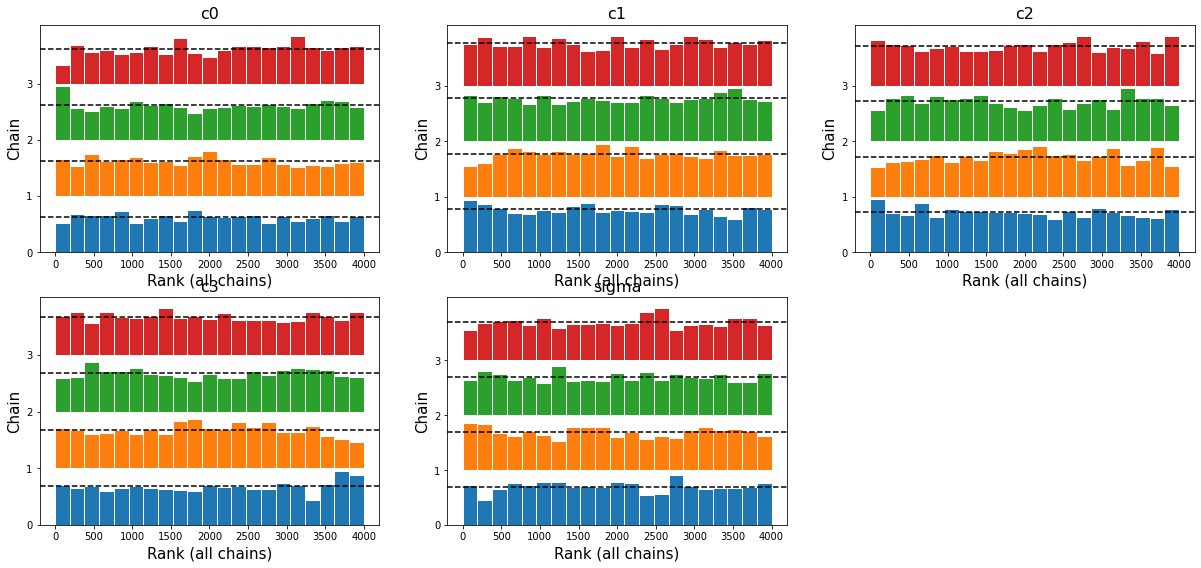

In [7]:
az.plot_rank(normal_inference3, var_names=['c0', 'c1', 'c2', 'c3', 'sigma'])
az.summary(normal_inference3, var_names=['c0', 'c1', 'c2', 'c3', 'sigma'])

The results from Diagnostic Plots look very positive here. We can see that R_hat values for all parameters are all 1.0, which nearly reaches perfection. Furthermore, the values of ESS which stands for Effective Sample Size are also very big, in terms of thousands. Finally, the rank plots are wonderful. All distributions of any chain look fairly uniform, which shows that all chains are doing the same jobs, start at the same place and end up at the same spot. Overall, results seem consistently positive!

#### c. Posteriors

After positive results of diagnosis, we can plot the posterior-predictive distribution with a credible interval to visualize how well our model is fitting the data.

In [8]:
with normal_model3:
    cereal_pred3 = pm.sample_posterior_predictive(normal_inference3)

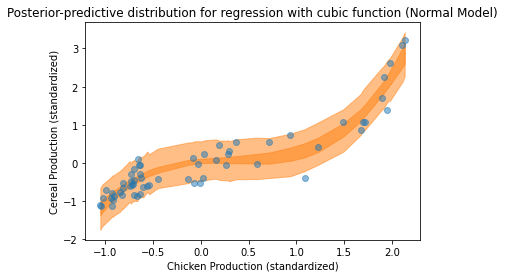

In [9]:
az.rcParams["stats.hdi_prob"] = 0.89
ax = az.plot_hdi(dataset.chicken_std, normal_inference3.posterior["mu"], smooth=False)
az.plot_hdi(dataset.chicken_std, cereal_pred3.posterior_predictive["pred"], ax=ax, smooth=False)
plt.scatter(dataset.chicken_std, dataset.cereal_std, alpha = 0.5)
plt.xlabel('Chicken Production (standardized)')
plt.ylabel('Cereal Production (standardized)')
plt.title('Posterior-predictive distribution for regression with cubic function (Normal Model)')
plt.show()

#### d. Evaluation

From the plot above, I can tell that the model is performing pretty well. There are no significant outliers in the data even though I admit that there can be 2 data points falling out of the 89% credible interval. However, I also accept that a perfect fit is very difficult. In addition, the model is capturing the pattern in the data very well without falling into the trap of overfitting too much. However, we can also try another model - Student T model to see if there could be an improvement here.

### 2. Student T Model

The Student T Model differs from the Normal Model in the distribution they assume data are generated from. While the Normal model assumes all data come from a Normal distribution, the Student T distribution assumes a Student T distribution instead which basically means a Normal distribution, yet with heavier tails. Therefore, these two models will use different likelihood function. Heavier tails help the model account for outliers because with Student T distribution, we are more likely to get elements too far away from the mean than the Normal distribution, which helps us account for outliers. 

We also use polynomial function here to conduct regression and also start with choosing the ideal degree of polynomials to balance between learning data and avoiding overfitting.

In [10]:
result = []
for degree in [1, 2, 3, 4, 5]:
    with pm.Model() as m:
        # Noise scale
        sigma = pm.Uniform('sigma', lower=0, upper=20)
        # Constant term
        alpha = pm.Uniform('alpha', lower=0, upper=10)
        # Coefficients of the x^i terms
        beta = pm.Normal('beta', size=degree, mu=0, sigma=1)
        # Compute the mean of the polynomial given the alpha and beta coefficients
        mu = alpha
        for i in range(1, degree + 1):
            mu = mu + beta[i-1] * dataset.chicken_std ** i
        mu = pm.Deterministic('mu', mu)
        nu = pm.HalfNormal('nu', sigma=30)
        # Likelihood
        y = pm.StudentT('y', mu=mu, nu=nu, sigma=sigma, observed=dataset.cereal_std)

        approx = pm.fit(50000, progressbar=False)

    log_evidence = -np.mean(approx.hist[-10000:])
    result.append(log_evidence)
    print(f'log evidence for degree {degree}:', log_evidence)

Finished [100%]: Average Loss = 46.237


log evidence for degree 1: -46.09318041076025


Finished [100%]: Average Loss = 49.112


log evidence for degree 2: -49.04430572489259


Finished [100%]: Average Loss = 37.054


log evidence for degree 3: -37.06529776223352


Finished [100%]: Average Loss = 38.468


log evidence for degree 4: -38.5971879979364


Finished [100%]: Average Loss = 43.215


log evidence for degree 5: -43.64429831550365


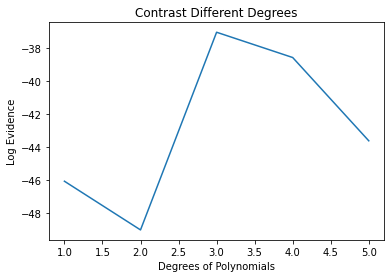

In [11]:
params = [1, 2, 3, 4, 5]
plt.plot(params, result)
plt.title("Contrast Different Degrees")
plt.xlabel("Degrees of Polynomials")
plt.ylabel("Log Evidence")
plt.show()

For Student T model, we still end up at the same conclusion which is **3 is the ideal degree of polynomial**

#### a. Model

Similarly with the Normal model, we also need to take care of ranges set to our prior. With justifications above, I maintained the same prior for Student T model. Besides, we have a new parameter of *nu* which refers to the degrees of freedom in the model. In other words, this parameter defines how heavy the tail of our Student T distribution will be. I choose a Half-Normal distribution because this parameter should be non-negative. Furthermore, the scale is 30 because we want to allow the Student T distribution to look like a Normal distribution, which helps the model flexible with outliers.

In [12]:
with pm.Model() as t_model3:
    # Prior
    c0 = pm.Uniform('c0', lower=0, upper=10)
    c1 = pm.Normal('c1', mu=0, sigma=5)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    nu = pm.HalfNormal('nu', sigma=30)
    
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * dataset.chicken_std + c2 * dataset.chicken_std2 + c3 * dataset.chicken_std**3)
    # Likelihood
    pm.StudentT('likelihood', nu=nu,
                mu=mu, sigma=sigma, observed=dataset.cereal_std)
    t_inference3 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, c2, c3, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8812, but should be close to 0.8. Try to increase the number of tuning steps.


#### b. Diagnostics Plot

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.054,0.044,0.000,0.112,0.001,0.001,1796.0,1323.0,1.0
c1,0.200,0.112,0.029,0.383,0.003,0.002,1692.0,2242.0,1.0
c2,-0.455,0.094,-0.604,-0.310,0.003,0.002,1331.0,1993.0,1.0
c3,0.461,0.071,0.343,0.569,0.002,0.001,1326.0,1920.0,1.0
sigma,0.313,0.034,0.259,0.366,0.001,0.000,2490.0,2136.0,1.0
nu,30.580,17.347,4.328,54.158,0.333,0.236,2283.0,2026.0,1.0


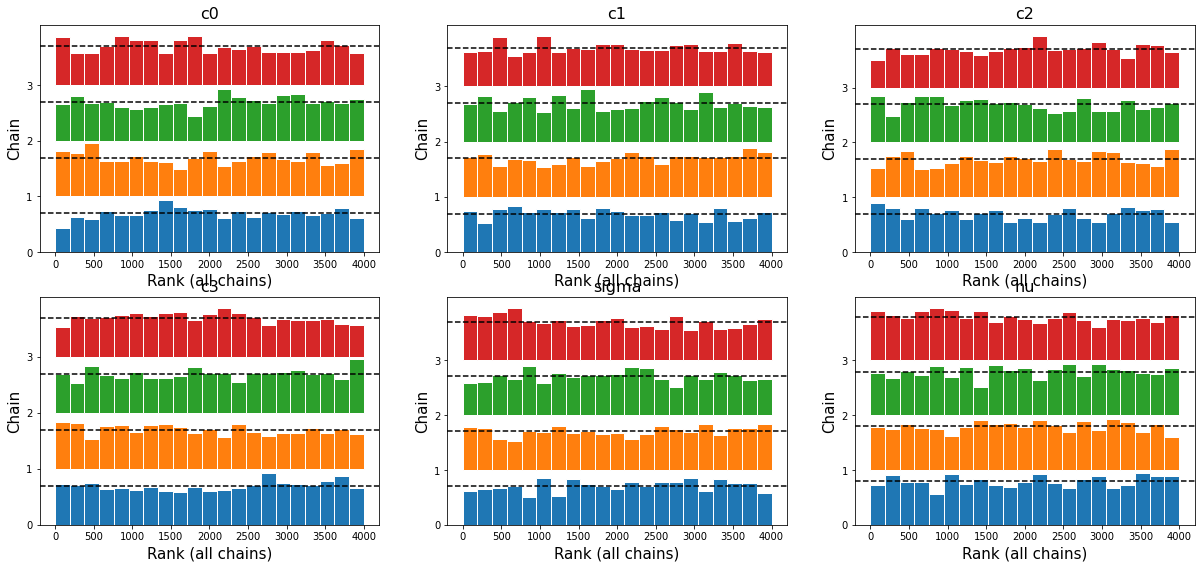

In [13]:
az.plot_rank(t_inference3, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu'])
az.summary(t_inference3, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'nu'])

From diagnosis results and plots, we can also see really good results. All R_hat values are 1.0 as they are supposed to be. All ESS values are really large, in terms of thousands. In terms of rank plots, we can see all chains in every plot are fairly uniform, which can explain 1.0 values of R_hat. Overall, our sampler is working fine.

One quick notice is that the mean value of *nu* parameter is slightly around 30 which makes the distribution pretty close to Normal distribution. Even though standard devidation of *nu* is pretty large, we can sense that both models share some similarities in performance.

#### c. Posteriors

In [14]:
with t_model3:
    cereal_pred_t3 = pm.sample_posterior_predictive(t_inference3)

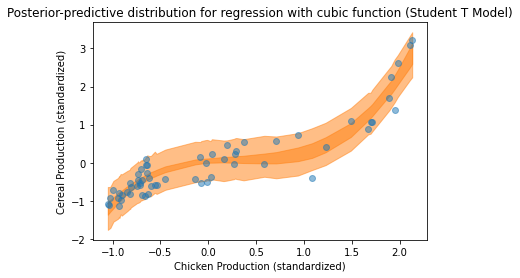

In [15]:
az.rcParams["stats.hdi_prob"] = 0.89
ax = az.plot_hdi(dataset.chicken_std, t_inference3.posterior["mu"], smooth=False)
az.plot_hdi(dataset.chicken_std, cereal_pred_t3.posterior_predictive["likelihood"], ax=ax, smooth=False)
plt.scatter(dataset.chicken_std, dataset.cereal_std, alpha = 0.5)
plt.xlabel('Chicken Production (standardized)')
plt.ylabel('Cereal Production (standardized)')
plt.title('Posterior-predictive distribution for regression with cubic function (Student T Model)')
plt.show()

#### d. Evaluation

We can see that the posterior predictive distribution for Student T model is pretty similar with the one for Normal model. This is somehow consistent with what we predict after seeing diagnostic results. From visual observations, I can see credible interval of Student T model is a bit away from one outlier, compared to the Normal model. I decided to print out the posterior distribution to compare between two models over our parameters.

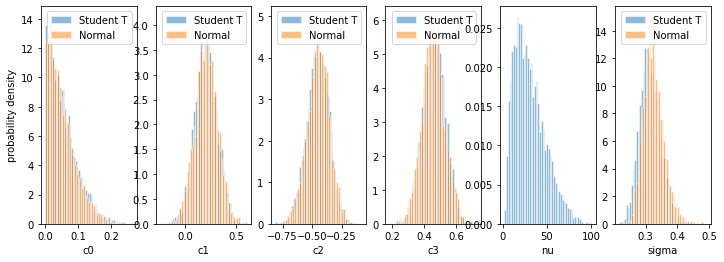

In [16]:
plt.figure(figsize=(12, 4))
for i, var in enumerate(['c0', 'c1', 'c2', 'c3', 'nu', 'sigma']):
    plt.subplot(1, 6, i+1)
    plt.xlabel(var)
    if i == 0:
        plt.ylabel('probability density')
    if var == "nu":
        plt.hist(getattr(t_inference3.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Student T')
        continue
    plt.hist(getattr(t_inference3.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Student T')
    plt.hist(getattr(normal_inference3.posterior, var).values.flatten(), density=True, bins=50, edgecolor='white', alpha=0.5, label='Normal')
    plt.legend()
plt.show()

From the posterior plots, we can see that both models pretty much end up at the same place. For parameters of the intercept and the coefficients, there seems to be negligible difference between the two models. Sigma shows a slight difference which might be the key here. In Student T model, sigma seems to be denser to the left, which means the variations in the outcome variable in Student T model should be generally smaller. For that reason, the credible interval of posterior-predictive distribution for Student T model might not be wide enough to capture outliers. Furthermore, if we look at the *nu* posterior distribution, it is most focused at around 30 which supports the idea that the Student T distribution here is also somewhat similar to Normal distribution

### 3. Outlier Detection Model

We move to another model called Outlier Detection Model. Instead of assuming one distribution over all data, this model assumes a Normal distribution over most of the data. For the rest, the model classified a few data points as fautily generated from Normal distribution. The determination of which data point is an outlier follows a Binomial distribution with the probability of success. Here, I set the prior for the probability of success to follow a uniform distribution from 0 to 0.3. I did not choose 0.5 to be the upper bound because a wide prior should be harmful to the model. Food and agrcultural production of Argentina is not expected to have too many sudden large increase or decrease year by year. Therefore, I kept 0.3 to still account for surprise, yet tried to minimize the prior range. Furthermore, another difference in this model is for data points classified as outliers, their sigma is also added another part to make the variations larger to adapt to the potential outliers.

#### a. Model

In [22]:
import aesara.tensor as at

with pm.Model() as outlier_model:
    
    # Observed variables
    x = pm.MutableData('x', dataset.chicken_std)
    y = pm.MutableData('y', dataset.cereal_std)
    
    # Linear regression
    c0 = pm.Uniform('c0', lower=0, upper=10)
    c1 = pm.Normal('c1', mu=0, sigma=5)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)

    mu = pm.Deterministic('mu', c0 + c1 * x + c2 * x**2 + c3 * x**3)
    
    # Noise parameters for inliers and outliers
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    sigma_out = pm.HalfNormal('sigma_out', sigma=30)
    sigmas = at.as_tensor_variable([sigma, sigma + sigma_out])

    # In/out class assignment probability and indicators
    p = pm.Uniform('p', lower=0, upper=0.3)
    is_outlier = pm.Bernoulli('is_outlier', p=p, size=x.shape[0])
    
    pm.Normal('likelihood', mu=mu, sigma=sigmas[is_outlier], observed=y)
    
with outlier_model:
    normal_outlier = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, c2, c3, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


#### b. Diagnostics Plot

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.052,0.042,0.000,0.106,0.001,0.001,1977.0,1919.0,1.00
c1,0.203,0.111,0.023,0.379,0.003,0.002,1357.0,2020.0,1.00
c2,-0.451,0.096,-0.600,-0.298,0.003,0.002,1278.0,1887.0,1.00
c3,0.457,0.071,0.344,0.565,0.002,0.001,1167.0,1789.0,1.00
sigma,0.322,0.032,0.271,0.371,0.001,0.001,1700.0,1300.0,1.00
p,0.025,0.037,0.000,0.052,0.003,0.002,404.0,251.0,1.01
sigma_out,20.766,18.746,0.009,45.661,0.614,0.434,394.0,254.0,1.01


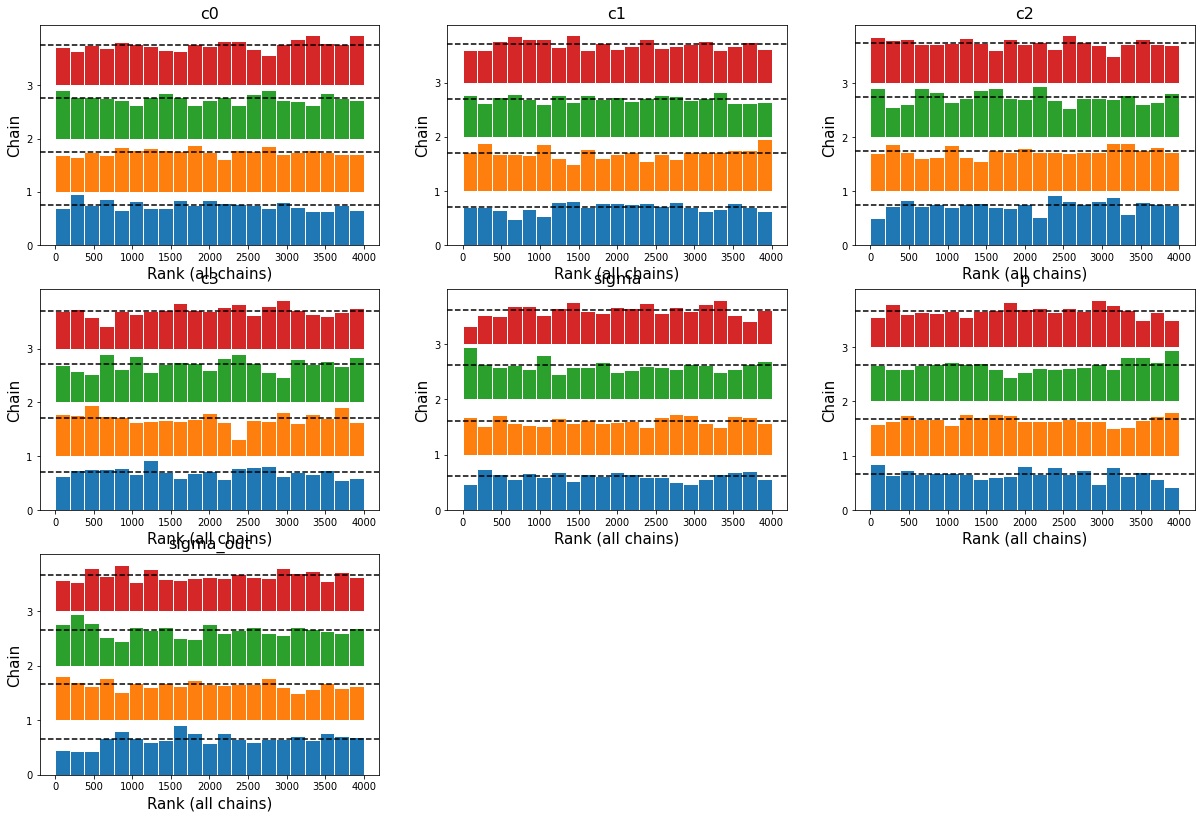

In [23]:
az.plot_rank(normal_outlier, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'p', 'sigma_out'])
az.summary(normal_outlier, var_names=['c0', 'c1', 'c2', 'c3', 'sigma', 'p', 'sigma_out'])

Results from diagnostic plots are still pretty positive. R_hat values are mostly 1.0 except for 2 parameters at 1.01 which we should not be too worried about. Furthermore, ESS values are still large with only 2 parameters fall into more than 500. Finally, all chains are pretty uniform, so we can claim that our sampler is working fine.

#### c. Posteriors

In [24]:
with outlier_model:
    cereal_pred_outlier = pm.sample_posterior_predictive(normal_outlier)

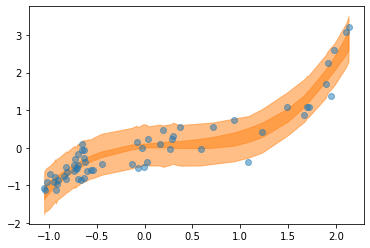

In [25]:
az.rcParams["stats.hdi_prob"] = 0.89
ax = az.plot_hdi(dataset.chicken_std, normal_outlier.posterior["mu"], smooth=False)
az.plot_hdi(dataset.chicken_std, cereal_pred_outlier.posterior_predictive["likelihood"], ax=ax, smooth=False)
plt.scatter(dataset.chicken_std, dataset.cereal_std, alpha = 0.5)

#### d. Evaluation

The plot looks pretty similar to the other 2 models we have worked on. As noted above, we only see that there are 2 data points always not captured in the credible interval of posterior-predictive distribution. However, these 2 data points are even not too far from interval. Therefore, we should not be too worried about outliers generally. This model can be an even worse choice for us because it involves a lot more parameters than the other two models, which can easily cause overfitting and computational expense. In addition, since the outlier classification is random based on different Bernoulli trials, this can also make our fitting potentially faulty at some point. Now, we can move to model comparison to further engage closely with 3 models.

# Model Comparison

For Model Comparison, we used PSIS leave-one-out cross-validation to compare 3 models above. Note that this metric is used to measure how well the model will perform at predicting out-of-sample data, not how well the model is fitting the data. By that, I mean we will try to find the model which can best learn from the data right enough to make useful predictions. Like given the chicken production, the model can predict the yearly cereal production.

/Users/ngttam3010/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

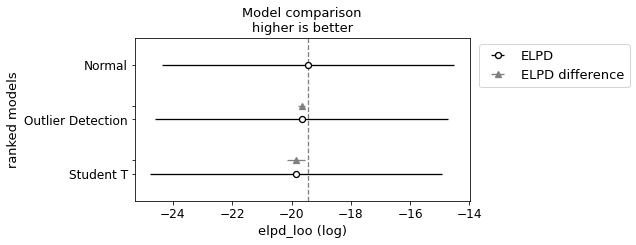

In [26]:
comparison_loo = az.compare({'Normal':normal_inference3, 'Student T' : t_inference3, 'Outlier Detection' : normal_outlier}, ic = 'loo')
az.plot_compare(comparison_loo)

From the plot above, we can see that the first model - Normal model turns out to be the best. I can tell that the Normal performs even strictly better than the other two when we looked at the relative difference variations on top of the empty dot for the final two models. The variations do not reach closer to point estimate of Normal model. Therefore, we can claim that the Normal model is best at predicting out-of-sample data compared to Student T and Outlier Detection Models.

# Conclusion

After the analysis of three models and a comparison based on the metric of PSIS leave-one-out cross-validation, we can claim that a traditional Normal model with cubic polynomial function is the best at predicting out-of-sample data. This somehow makes sense to me because Student T model and Outlier Detection are supposed to perform better at adjusting the model to outliers. However, in our original data, outliers are not even really present. Therefore, with quite simple data, a Normal model with ideal degree of polynomials for regression is already good enough. A more complicated model can increase robustness, yet also increase the chance of overfitting due to a large number of parameters.